# Multi-Modality PET/CT Registration Pipeline
**Purpose:** Align PET/CT diagnostic scan with treatment planning CT for radiation therapy target contouring

**Workflow:**
1. Scan DICOM directory and classify series by modality
2. Build 3D volumes from sorted slices
3. Resample to 5mm isotropic resolution
4. Perform bone-driven rigid registration (CT2 → CT1)
5. Align PET to CT1 coordinate system
6. Visualize multi-modality overlays with quality metrics

**Requirements:** pydicom, numpy, matplotlib, scipy, scikit-image

In [1]:
# === 1. ENVIRONMENT SETUP ===
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Check and install dependencies
try:
    import pydicom
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import ndimage
    from skimage.registration import phase_cross_correlation
    print("✓ All dependencies loaded successfully")
except ImportError as e:
    print(f"Missing dependency: {e}")
    print("Installing required packages...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", 
                          "pydicom", "numpy", "matplotlib", "scipy", "scikit-image"])
    print("Please restart the kernel and run again")
    raise

✓ All dependencies loaded successfully


In [2]:
# === 2. CONFIGURATION ===
# Set input directory (modify this path for different patients)
INPUT_DICOM_DIR = r'c:\Users\zhaoanr\Desktop\WholePelvis2'

# Verify directory exists
if not os.path.isdir(INPUT_DICOM_DIR):
    raise FileNotFoundError(f"Directory not found: {INPUT_DICOM_DIR}")

print(f"✓ Input directory: {INPUT_DICOM_DIR}")
print(f"  Absolute path: {os.path.abspath(INPUT_DICOM_DIR)}")

✓ Input directory: c:\Users\zhaoanr\Desktop\WholePelvis2
  Absolute path: c:\Users\zhaoanr\Desktop\WholePelvis2


In [3]:
# === 3. DICOM DIRECTORY SCANNING ===
from collections import defaultdict

def scan_dicom_directory(root_dir):
    """Recursively scan directory and classify DICOM series by UID and modality."""
    series_map = defaultdict(lambda: {'header': None, 'modality': 'Unknown', 'files': []})
    file_count = 0
    skipped_files = 0
    
    print(f"Scanning: {root_dir}")
    
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            try:
                # Read header only (no pixel data)
                header = pydicom.dcmread(filepath, stop_before_pixels=True, force=True)
                file_count += 1
                
                # Require SeriesInstanceUID and Modality
                if 'SeriesInstanceUID' not in header or 'Modality' not in header:
                    skipped_files += 1
                    continue
                
                series_uid = header.SeriesInstanceUID
                modality = header.Modality.upper()
                
                # Store first header as representative
                if series_map[series_uid]['header'] is None:
                    series_map[series_uid]['header'] = header
                    series_map[series_uid]['modality'] = modality
                
                series_map[series_uid]['files'].append(filepath)
                
            except Exception:
                skipped_files += 1
                continue
    
    print(f"  Processed: {file_count} files")
    print(f"  Skipped: {skipped_files} files")
    print(f"  Found: {len(series_map)} unique series")
    
    return dict(series_map)

# Execute scan
series_map = scan_dicom_directory(INPUT_DICOM_DIR)

Scanning: c:\Users\zhaoanr\Desktop\WholePelvis2
  Processed: 4886 files
  Skipped: 0 files
  Found: 231 unique series


In [4]:
# === 4. SERIES CLASSIFICATION AND BINNING ===

def classify_series(series_map):
    """Bin series by modality and clinical context."""
    bins = {
        'PET': {},
        'CT_ORIGINAL': {},
        'CT_PLANNING_SIM': {},
        'CT_OTHER': {},
        'MRI': {},
        'REG': {},
        'RTSTRUCT': {},
        'RTDOSE': {},
        'RTIMAGE': {},
        'OTHER_MODALITY': {}
    }
    
    # Identify original study via first PET series
    pet_series = [(uid, info) for uid, info in series_map.items() 
                  if info['modality'] in ['PT', 'PET']]
    
    original_study_uid = None
    if pet_series:
        original_study_uid = pet_series[0][1]['header'].StudyInstanceUID
        print(f"Original PET/CT Study UID: ...{str(original_study_uid)[-12:]}")
    else:
        print("⚠ No PET series found - cannot identify original vs planning CT")
    
    # Classify each series
    for series_uid, series_info in series_map.items():
        modality = series_info['modality']
        header = series_info['header']
        study_uid = header.get('StudyInstanceUID', None)
        series_desc = str(header.get('SeriesDescription', '')).upper()
        
        if modality in ['PT', 'PET']:
            bins['PET'][series_uid] = series_info
        
        elif modality == 'CT':
            # Original CT (same study as PET)
            if original_study_uid and study_uid == original_study_uid:
                bins['CT_ORIGINAL'][series_uid] = series_info
            
            # Planning CT (different study with planning keywords)
            elif original_study_uid and study_uid != original_study_uid:
                if any(kw in series_desc for kw in ['SIM', 'PLAN', 'IMAR', 'PELVIS', 'RT']):
                    bins['CT_PLANNING_SIM'][series_uid] = series_info
                # Fallback: if only one other CT series exists
                elif len(bins['CT_PLANNING_SIM']) == 0:
                    other_ct = [s for s in series_map.values() 
                               if s['modality'] == 'CT' and 
                               s['header'].StudyInstanceUID != original_study_uid]
                    if len(other_ct) == 1:
                        bins['CT_PLANNING_SIM'][series_uid] = series_info
                    else:
                        bins['CT_OTHER'][series_uid] = series_info
                else:
                    bins['CT_OTHER'][series_uid] = series_info
            else:
                bins['CT_OTHER'][series_uid] = series_info
        
        elif modality in ['MR', 'MRI']:
            bins['MRI'][series_uid] = series_info
        elif modality == 'REG':
            bins['REG'][series_uid] = series_info
        elif modality == 'RTSTRUCT':
            bins['RTSTRUCT'][series_uid] = series_info
        elif modality == 'RTDOSE':
            bins['RTDOSE'][series_uid] = series_info
        elif modality == 'RTIMAGE':
            bins['RTIMAGE'][series_uid] = series_info
        else:
            bins['OTHER_MODALITY'][series_uid] = series_info
    
    return bins

# Execute classification
bins = classify_series(series_map)

# Print summary
print("\n" + "="*60)
print("SERIES CLASSIFICATION SUMMARY")
print("="*60)
for bin_name, series_dict in bins.items():
    count = len(series_dict)
    if count > 0:
        print(f"\n{bin_name}: {count} series")
        for series_uid, series_info in series_dict.items():
            header = series_info['header']
            desc = header.get('SeriesDescription', 'N/A')
            date = header.get('SeriesDate', 'N/A')
            num_files = len(series_info['files'])
            print(f"  • ...{series_uid[-12:]} | {date} | '{desc}' ({num_files} files)")
print("="*60)

Original PET/CT Study UID: ...490848309160

SERIES CLASSIFICATION SUMMARY

PET: 3 series
  • ...628000813747 | 20240807 | 'PET WB Uncorrected (NAC)' (368 files)
  • ...279970265732 | 20240807 | 'PET WB  (AC)' (368 files)
  • ...946365746610 | 20240807 | 'MIP' (32 files)

CT_ORIGINAL: 3 series
  • ...221440256152 | 20240807 | 'CT WB  4.0  B31s' (551 files)
  • ...171401697457 | 20240807 | 'Topogram  0.6  T80s' (1 files)
  • ...686431455142 | 20240807 | 'Patient Protocol' (1 files)

CT_PLANNING_SIM: 1 series
  • ...608440078742 | 20250808 | 'PELVIS  1.5  Br32  3 iMAR' (334 files)

CT_OTHER: 31 series
  • ...827152277916 | 20250918 | 'N/A' (88 files)
  • ...615945172109 | 20251001 | 'N/A' (88 files)
  • ...881996981670 | 20250826 | 'N/A' (88 files)
  • ...412636964766 | 20250911 | 'N/A' (88 files)
  • ...222131643282 | 20250903 | 'N/A' (88 files)
  • ...842487301277 | 20250930 | 'N/A' (88 files)
  • ...738262368187 | 20250902 | 'N/A' (88 files)
  • ...328893362562 | 20250829 | 'N/A' (88 f

In [5]:
# === 5. ROBUST SLICE SORTING ===

def sort_series_by_position(file_list):
    """Sort DICOM slices by ImagePositionPatient Z or InstanceNumber."""
    import pandas as pd
    
    slice_data = []
    for filepath in file_list:
        try:
            header = pydicom.dcmread(filepath, stop_before_pixels=True, 
                                    specific_tags=['ImagePositionPatient', 'InstanceNumber'], 
                                    force=True)
            
            sort_key = None
            
            # Prefer ImagePositionPatient Z-coordinate
            if 'ImagePositionPatient' in header:
                try:
                    sort_key = float(header.ImagePositionPatient[2])
                except (TypeError, ValueError, IndexError):
                    pass
            
            # Fallback to InstanceNumber
            if sort_key is None and 'InstanceNumber' in header:
                try:
                    sort_key = int(header.InstanceNumber)
                except (TypeError, ValueError):
                    pass
            
            if sort_key is not None:
                slice_data.append({'filepath': filepath, 'SortKey': sort_key})
        
        except Exception:
            continue
    
    if not slice_data:
        raise ValueError("No sortable slices found in series")
    
    df = pd.DataFrame(slice_data)
    df = df.sort_values('SortKey', ascending=True).reset_index(drop=True)
    return df

# Test sorting on available series
print("Testing slice sorting...")
if bins['CT_ORIGINAL']:
    test_uid = list(bins['CT_ORIGINAL'].keys())[0]
    test_files = bins['CT_ORIGINAL'][test_uid]['files']
    df_test = sort_series_by_position(test_files)
    print(f"✓ Sorted {len(df_test)} CT slices successfully")

Testing slice sorting...
✓ Sorted 551 CT slices successfully


In [6]:
# === 6. VOLUME ASSEMBLY ===

def build_volume_from_series(file_list, series_name="Volume"):
    """Build 3D volume from sorted DICOM slices with RescaleSlope/Intercept."""
    
    # Sort slices
    df_sorted = sort_series_by_position(file_list)
    depth = len(df_sorted)
    
    # Read first slice to get dimensions
    first_ds = pydicom.dcmread(df_sorted.iloc[0]['filepath'], force=True)
    rows, cols = first_ds.pixel_array.shape
    
    # Initialize volume
    volume = np.zeros((rows, cols, depth), dtype=np.float32)
    
    print(f"Building {series_name}: ({rows}, {cols}, {depth})")
    
    for i in range(depth):
        try:
            ds = pydicom.dcmread(df_sorted.iloc[i]['filepath'], force=True)
            arr = ds.pixel_array.astype(np.float32)
            
            # Apply rescale
            slope = float(ds.get('RescaleSlope', 1.0))
            intercept = float(ds.get('RescaleIntercept', 0.0))
            arr = arr * slope + intercept
            
            # Handle shape mismatch
            if arr.shape == (rows, cols):
                volume[:, :, i] = arr
            else:
                # Center-crop or pad
                tmp = np.zeros((rows, cols), dtype=np.float32)
                min_r = min(arr.shape[0], rows)
                min_c = min(arr.shape[1], cols)
                tmp[:min_r, :min_c] = arr[:min_r, :min_c]
                volume[:, :, i] = tmp
        
        except Exception as e:
            print(f"  ⚠ Error slice {i}: {e}")
            volume[:, :, i] = 0
    
    return volume, df_sorted

# Build all three volumes
print("\n" + "="*60)
print("BUILDING VOLUMES")
print("="*60)

# CT1 (Original PET/CT)
if not bins['CT_ORIGINAL']:
    raise ValueError("No CT_ORIGINAL series found")
ct1_uid = list(bins['CT_ORIGINAL'].keys())[0]
ct1_files = bins['CT_ORIGINAL'][ct1_uid]['files']
CT_1, df_ct1 = build_volume_from_series(ct1_files, "CT_1 (PET/CT)")

# PET
if not bins['PET']:
    raise ValueError("No PET series found")
pet_uid = list(bins['PET'].keys())[0]
pet_files = bins['PET'][pet_uid]['files']
PET, df_pet = build_volume_from_series(pet_files, "PET")

# CT2 (Planning)
if not bins['CT_PLANNING_SIM']:
    raise ValueError("No CT_PLANNING_SIM series found")
ct2_uid = list(bins['CT_PLANNING_SIM'].keys())[0]
ct2_files = bins['CT_PLANNING_SIM'][ct2_uid]['files']
CT_2, df_ct2 = build_volume_from_series(ct2_files, "CT_2 (Planning)")

print("\n✓ All volumes built successfully")


BUILDING VOLUMES
Building CT_1 (PET/CT): (512, 512, 551)
Building PET: (168, 168, 368)
Building CT_2 (Planning): (512, 512, 334)

✓ All volumes built successfully


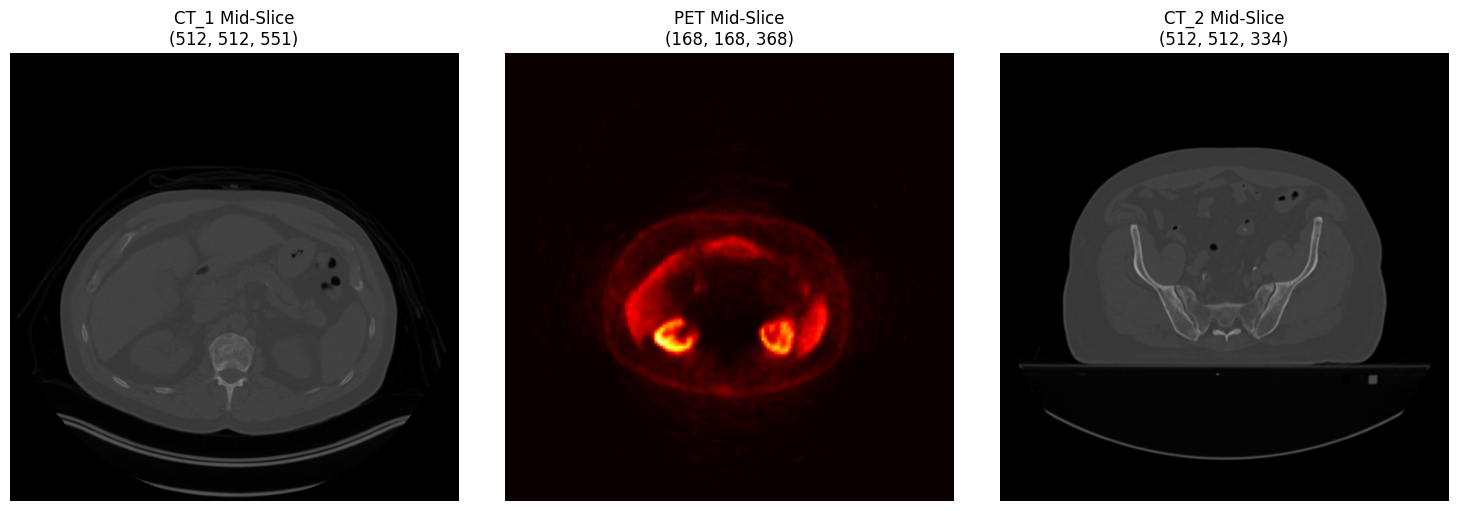

In [7]:
# === 7. QUICK VOLUME PREVIEW ===

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(CT_1[:, :, CT_1.shape[2]//2], cmap='gray', vmin=-1000, vmax=3000)
axes[0].set_title(f'CT_1 Mid-Slice\n{CT_1.shape}')
axes[0].axis('off')

axes[1].imshow(PET[:, :, PET.shape[2]//2], cmap='hot')
axes[1].set_title(f'PET Mid-Slice\n{PET.shape}')
axes[1].axis('off')

axes[2].imshow(CT_2[:, :, CT_2.shape[2]//2], cmap='gray', vmin=-1000, vmax=3000)
axes[2].set_title(f'CT_2 Mid-Slice\n{CT_2.shape}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [8]:
# === 8. EXTRACT DICOM GEOMETRY METADATA ===

def extract_volume_metadata(df_sorted):
    """Extract spatial metadata from sorted DICOM series."""
    first_ds = pydicom.dcmread(df_sorted.iloc[0]['filepath'], stop_before_pixels=True, force=True)
    
    # Pixel spacing [row_spacing, col_spacing]
    pixel_spacing = [float(x) for x in first_ds.get('PixelSpacing', [1.0, 1.0])]
    
    # Slice spacing (compute from ImagePositionPatient if available)
    if len(df_sorted) > 1:
        try:
            pos0 = np.array([float(x) for x in first_ds.ImagePositionPatient])
            ds1 = pydicom.dcmread(df_sorted.iloc[1]['filepath'], stop_before_pixels=True, force=True)
            pos1 = np.array([float(x) for x in ds1.ImagePositionPatient])
            slice_spacing = float(np.linalg.norm(pos1 - pos0))
        except Exception:
            slice_spacing = float(first_ds.get('SliceThickness', 1.0))
    else:
        slice_spacing = float(first_ds.get('SliceThickness', 1.0))
    
    # Origin and orientation
    origin = np.array([float(x) for x in first_ds.get('ImagePositionPatient', [0, 0, 0])])
    orientation = [float(x) for x in first_ds.get('ImageOrientationPatient', [1,0,0,0,1,0])]
    
    metadata = {
        'spacing': [pixel_spacing[0], pixel_spacing[1], slice_spacing],
        'origin': origin,
        'orientation': orientation,
        'dimensions': [int(first_ds.Rows), int(first_ds.Columns), len(df_sorted)],
        'for_uid': str(first_ds.get('FrameOfReferenceUID', ''))
    }
    
    return metadata

# Extract metadata for all volumes
ct1_meta = extract_volume_metadata(df_ct1)
pet_meta = extract_volume_metadata(df_pet)
ct2_meta = extract_volume_metadata(df_ct2)

print("\nVolume Metadata:")
print(f"CT_1: spacing={np.round(ct1_meta['spacing'], 2)} mm, dims={ct1_meta['dimensions']}")
print(f"PET:  spacing={np.round(pet_meta['spacing'], 2)} mm, dims={pet_meta['dimensions']}")
print(f"CT_2: spacing={np.round(ct2_meta['spacing'], 2)} mm, dims={ct2_meta['dimensions']}")


Volume Metadata:
CT_1: spacing=[0.98 0.98 2.  ] mm, dims=[512, 512, 551]
PET:  spacing=[4.07 4.07 3.  ] mm, dims=[168, 168, 368]
CT_2: spacing=[0.98 0.98 1.5 ] mm, dims=[512, 512, 334]


In [9]:
# === 9. ISOTROPIC RESAMPLING TO 5mm ===

def resample_to_isotropic(volume, original_spacing, target_spacing=5.0, order=1):
    """Resample volume to isotropic voxel spacing using trilinear interpolation."""
    
    # Calculate scale factors
    scale = np.array(original_spacing) / target_spacing
    
    # Calculate new dimensions
    new_shape = np.round(np.array(volume.shape) * scale).astype(int)
    
    # Create coordinate grids
    coords = np.meshgrid(
        np.linspace(0, volume.shape[0]-1, new_shape[0]),
        np.linspace(0, volume.shape[1]-1, new_shape[1]),
        np.linspace(0, volume.shape[2]-1, new_shape[2]),
        indexing='ij'
    )
    
    coords = np.stack(coords, axis=0)
    
    # Resample using map_coordinates
    resampled = ndimage.map_coordinates(
        volume, coords, order=order, mode='constant', cval=-1024.0
    ).astype(np.float32)
    
    return resampled

print("\n" + "="*60)
print("RESAMPLING TO 5mm ISOTROPIC")
print("="*60)

ct1_iso = resample_to_isotropic(CT_1, ct1_meta['spacing'], 5.0)
ct1_iso_meta = ct1_meta.copy()
ct1_iso_meta['spacing'] = [5.0, 5.0, 5.0]
ct1_iso_meta['dimensions'] = list(ct1_iso.shape)
print(f"CT_1: {CT_1.shape} → {ct1_iso.shape}")

pet_iso = resample_to_isotropic(PET, pet_meta['spacing'], 5.0)
pet_iso_meta = pet_meta.copy()
pet_iso_meta['spacing'] = [5.0, 5.0, 5.0]
pet_iso_meta['dimensions'] = list(pet_iso.shape)
print(f"PET:  {PET.shape} → {pet_iso.shape}")

ct2_iso = resample_to_isotropic(CT_2, ct2_meta['spacing'], 5.0)
ct2_iso_meta = ct2_meta.copy()
ct2_iso_meta['spacing'] = [5.0, 5.0, 5.0]
ct2_iso_meta['dimensions'] = list(ct2_iso.shape)
print(f"CT_2: {CT_2.shape} → {ct2_iso.shape}")

print("\n✓ All volumes resampled to 5mm isotropic")


RESAMPLING TO 5mm ISOTROPIC
CT_1: (512, 512, 551) → (100, 100, 220)
PET:  (168, 168, 368) → (137, 137, 221)
CT_2: (512, 512, 334) → (100, 100, 100)

✓ All volumes resampled to 5mm isotropic


In [10]:
# === 10. GEOMETRY VALIDATION ===

def compute_geometry_info(volume, metadata):
    """Compute detailed geometry for validation."""
    
    # Direction cosines
    iop = np.array(metadata['orientation'])
    row_cos = iop[0:3]
    col_cos = iop[3:6]
    slc_cos = np.cross(row_cos, col_cos)
    
    # Normalize
    for vec in [row_cos, col_cos, slc_cos]:
        norm = np.linalg.norm(vec)
        if norm > 0:
            vec /= norm
    
    # Bounding box
    R, C, K = volume.shape
    spacing = np.array(metadata['spacing'])
    origin = np.array(metadata['origin'])
    
    # Build affine matrix
    M = np.column_stack([
        col_cos * spacing[0],  # rows
        row_cos * spacing[1],  # cols
        slc_cos * spacing[2]   # slices
    ])
    
    # Corner points in patient space
    corners_idx = np.array(np.meshgrid([0, R-1], [0, C-1], [0, K-1], indexing='ij')).reshape(3, -1)
    corners_xyz = origin.reshape(3, 1) + M @ corners_idx
    
    bb_min = corners_xyz.min(axis=1)
    bb_max = corners_xyz.max(axis=1)
    center = corners_xyz.mean(axis=1)
    
    # Slice positions along normal
    k_indices = np.arange(K, dtype=float)
    slice_origins = origin.reshape(3, 1) + M @ np.vstack([np.zeros((2, K)), k_indices])
    svals = np.dot(slice_origins.T, slc_cos)
    
    return {
        'row_cos': row_cos,
        'col_cos': col_cos,
        'slc_cos': slc_cos,
        'affine': M,
        'origin': origin,
        'bb_min': bb_min,
        'bb_max': bb_max,
        'center': center,
        'svals': svals,
        'for_uid': metadata['for_uid']
    }

ct1_geom = compute_geometry_info(ct1_iso, ct1_iso_meta)
pet_geom = compute_geometry_info(pet_iso, pet_iso_meta)
ct2_geom = compute_geometry_info(ct2_iso, ct2_iso_meta)

# Check orientation alignment
def angle_between(v1, v2):
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    cos_angle = np.clip(np.dot(v1, v2), -1.0, 1.0)
    return np.degrees(np.arccos(cos_angle))

print("\n" + "="*60)
print("GEOMETRY VALIDATION")
print("="*60)
print(f"CT1 center: {np.round(ct1_geom['center'], 1)}")
print(f"CT2 center: {np.round(ct2_geom['center'], 1)}")
print(f"PET center: {np.round(pet_geom['center'], 1)}")
print(f"\nOrientation angles (degrees):")
print(f"  CT1 ↔ CT2 slice normal: {angle_between(ct1_geom['slc_cos'], ct2_geom['slc_cos']):.2f}°")
print(f"  CT1 ↔ PET slice normal: {angle_between(ct1_geom['slc_cos'], pet_geom['slc_cos']):.2f}°")
print(f"\nFrame of Reference match:")
print(f"  CT1 ↔ PET: {ct1_geom['for_uid'] == pet_geom['for_uid']}")
print(f"  CT1 ↔ CT2: {ct1_geom['for_uid'] == ct2_geom['for_uid']}")


GEOMETRY VALIDATION
CT1 center: [  -2.  -200.  -899.5]
CT2 center: [  -2.  -164.    94.6]
PET center: [  -1.8 -201.6 -897.1]

Orientation angles (degrees):
  CT1 ↔ CT2 slice normal: 0.00°
  CT1 ↔ PET slice normal: 0.00°

Frame of Reference match:
  CT1 ↔ PET: True
  CT1 ↔ CT2: False


In [11]:
# === 11. PET TO CT1 ALIGNMENT ===

def resample_via_affine(src_vol, src_geom, ref_geom, order=1, cval=0.0):
    """Resample source volume into reference coordinate system."""
    R, C, K = ref_geom['affine'].shape[0], ref_geom['affine'].shape[0], len(ref_geom['svals'])
    R, C, K = ct1_iso.shape  # Use actual reference dimensions
    
    M_src = src_geom['affine']
    M_ref = ref_geom['affine']
    O_src = src_geom['origin']
    O_ref = ref_geom['origin']
    
    # Create reference grid
    coords_grid = np.meshgrid(
        np.arange(R, dtype=np.float32),
        np.arange(C, dtype=np.float32),
        np.arange(K, dtype=np.float32),
        indexing='ij'
    )
    
    coords_ref = np.stack([g.ravel() for g in coords_grid], axis=0)
    
    # Transform to patient space
    P = O_ref.reshape(3, 1) + M_ref @ coords_ref
    
    # Transform to source indices
    M_src_inv = np.linalg.inv(M_src)
    src_coords = M_src_inv @ (P - O_src.reshape(3, 1))
    
    src_coords = src_coords.reshape(3, R, C, K)
    
    # Resample
    resampled = ndimage.map_coordinates(
        src_vol, src_coords, order=order, mode='constant', cval=cval
    ).astype(np.float32)
    
    return resampled

# Check if PET and CT1 share frame of reference
same_for = (pet_geom['for_uid'] != '' and pet_geom['for_uid'] == ct1_geom['for_uid'])
iop_close = angle_between(pet_geom['slc_cos'], ct1_geom['slc_cos']) < 1.0

print("\n" + "="*60)
print("PET → CT1 ALIGNMENT")
print("="*60)

if same_for and iop_close:
    print("Using DICOM affine transformation (same FrameOfReference)")
    pet_aligned = resample_via_affine(pet_iso, pet_geom, ct1_geom, order=1, cval=0.0)
else:
    print("Using center-embed fallback (different FrameOfReference)")
    # Center-embed PET into CT1 grid
    pet_aligned = np.zeros(ct1_iso.shape, dtype=np.float32)
    start = [(ct1_iso.shape[i] - pet_iso.shape[i]) // 2 for i in range(3)]
    end = [start[i] + pet_iso.shape[i] for i in range(3)]
    
    # Handle dimension mismatches
    for i in range(3):
        if end[i] > ct1_iso.shape[i]:
            end[i] = ct1_iso.shape[i]
        if start[i] < 0:
            start[i] = 0
    
    src_end = [min(pet_iso.shape[i], end[i] - start[i]) for i in range(3)]
    pet_aligned[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = \
        pet_iso[:src_end[0], :src_end[1], :src_end[2]]

print(f"✓ PET aligned: shape={pet_aligned.shape}, nonzero={np.count_nonzero(pet_aligned > 0)}")


PET → CT1 ALIGNMENT
Using DICOM affine transformation (same FrameOfReference)
✓ PET aligned: shape=(100, 100, 220), nonzero=2154759


In [12]:
# === 12. BONE EXTRACTION FOR REGISTRATION ===

def extract_bone_mask(ct_volume, hu_threshold=200, sigma=0.8):
    """Extract cortical bone mask for rigid registration."""
    bone_mask = (ct_volume > hu_threshold).astype(np.float32)
    
    # Light smoothing to reduce noise
    if sigma > 0:
        bone_mask = ndimage.gaussian_filter(bone_mask, sigma=sigma)
    
    return bone_mask

print("\n" + "="*60)
print("BONE FEATURE EXTRACTION")
print("="*60)

ct1_bone = extract_bone_mask(ct1_iso, hu_threshold=200, sigma=0.8)
ct2_bone = extract_bone_mask(ct2_iso, hu_threshold=200, sigma=0.8)

bone1_count = int(np.sum(ct1_bone > 0.1))
bone2_count = int(np.sum(ct2_bone > 0.1))

print(f"CT1 bone voxels: {bone1_count} ({100*bone1_count/ct1_bone.size:.2f}%)")
print(f"CT2 bone voxels: {bone2_count} ({100*bone2_count/ct2_bone.size:.2f}%)")

if bone1_count < 1000 or bone2_count < 1000:
    print("⚠ Warning: Very few bone voxels detected - registration may be unreliable")


BONE FEATURE EXTRACTION
CT1 bone voxels: 100564 (4.57%)
CT2 bone voxels: 30432 (3.04%)


In [13]:
# === 13. BONE-DRIVEN PHASE CORRELATION REGISTRATION ===

def center_crop_3d(volume, target_shape):
    """Center-crop or pad volume to target shape."""
    output = np.zeros(target_shape, dtype=volume.dtype)
    
    src_start = [max(0, (volume.shape[i] - target_shape[i]) // 2) for i in range(3)]
    src_end = [src_start[i] + min(volume.shape[i], target_shape[i]) for i in range(3)]
    
    dst_start = [max(0, (target_shape[i] - volume.shape[i]) // 2) for i in range(3)]
    dst_end = [dst_start[i] + (src_end[i] - src_start[i]) for i in range(3)]
    
    output[dst_start[0]:dst_end[0], dst_start[1]:dst_end[1], dst_start[2]:dst_end[2]] = \
        volume[src_start[0]:src_end[0], src_start[1]:src_end[1], src_start[2]:src_end[2]]
    
    return output

print("\n" + "="*60)
print("CT2 → CT1 BONE-DRIVEN REGISTRATION")
print("="*60)

# Crop to common shape
common_shape = tuple(np.minimum(ct1_bone.shape, ct2_bone.shape))
print(f"Common shape for correlation: {common_shape}")

ref_bone = center_crop_3d(ct1_bone, common_shape)
mov_bone = center_crop_3d(ct2_bone, common_shape)

ref_mask = (ref_bone > 0.1).astype(bool)
mov_mask = (mov_bone > 0.1).astype(bool)

# Phase correlation with high upsampling
shift_vox, error, _ = phase_cross_correlation(
    ref_bone, mov_bone,
    reference_mask=ref_mask,
    moving_mask=mov_mask,
    upsample_factor=10,
    overlap_ratio=0.3
)

shift_vox = shift_vox.astype(np.float32)
shift_mm = shift_vox * 5.0  # Convert to mm (5mm spacing)

print(f"Detected shift:")
print(f"  Voxels (rows, cols, slices): {shift_vox}")
print(f"  Physical (mm): {shift_mm}")
print(f"  Correlation error: {error:.6f}")


CT2 → CT1 BONE-DRIVEN REGISTRATION
Common shape for correlation: (np.int64(100), np.int64(100), np.int64(100))
Detected shift:
  Voxels (rows, cols, slices): [ 15.  -2. -33.]
  Physical (mm): [  75.  -10. -165.]
  Correlation error: nan


In [14]:
# === 14. APPLY TRANSFORMATION TO CT2 ===

def center_embed_3d(volume, target_shape, fill_value=-1024.0):
    """Embed volume in center of larger array."""
    output = np.full(target_shape, fill_value, dtype=np.float32)
    
    start = [(target_shape[i] - volume.shape[i]) // 2 for i in range(3)]
    end = [start[i] + volume.shape[i] for i in range(3)]
    
    # Clip to valid range
    for i in range(3):
        start[i] = max(0, start[i])
        end[i] = min(target_shape[i], end[i])
    
    src_end = [min(volume.shape[i], end[i] - start[i]) for i in range(3)]
    
    output[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = \
        volume[:src_end[0], :src_end[1], :src_end[2]]
    
    return output, np.array(start, dtype=np.int32)

print("\nApplying transformation to CT2...")

# Embed CT2 into CT1 grid
ct2_embedded, embed_offset = center_embed_3d(ct2_iso, ct1_iso.shape, fill_value=-1024.0)

# Apply shift
CT2_aligned = ndimage.shift(
    ct2_embedded, shift=shift_vox, order=1, 
    mode='constant', cval=-1024.0, prefilter=True
).astype(np.float32)

nonzero_count = int(np.count_nonzero(CT2_aligned > -900))
print(f"  Embed offset: {embed_offset}")
print(f"  Aligned CT2 nonzero voxels: {nonzero_count} ({100*nonzero_count/CT2_aligned.size:.2f}%)")

# Identify valid slices (where CT2 has data)
valid_slices = []
for z in range(CT2_aligned.shape[2]):
    if np.count_nonzero(CT2_aligned[:, :, z] > -900) > 100:
        valid_slices.append(z)

print(f"  Valid CT2 slices: {len(valid_slices)} / {CT2_aligned.shape[2]}")
if valid_slices:
    print(f"  Range: {min(valid_slices)} to {max(valid_slices)}")


Applying transformation to CT2...
  Embed offset: [ 0  0 60]
  Aligned CT2 nonzero voxels: 335194 (15.24%)
  Valid CT2 slices: 100 / 220
  Range: 27 to 126


In [15]:
# === 15. COMPUTE BONE ALIGNMENT QUALITY (IoU) ===

def compute_bone_iou(ct1_slice, ct2_slice, threshold=200):
    """Compute Intersection over Union for bone masks."""
    mask1 = (ct1_slice > threshold).astype(bool)
    mask2 = (ct2_slice > threshold).astype(bool)
    
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    
    if union == 0:
        return 0.0
    
    return float(intersection) / float(union)

# Compute IoU for mid-slice as quick check
mid_slice = ct1_iso.shape[2] // 2
if mid_slice in valid_slices:
    iou_mid = compute_bone_iou(ct1_iso[:, :, mid_slice], CT2_aligned[:, :, mid_slice])
    print(f"\nBone IoU at mid-slice {mid_slice}: {iou_mid:.3f}")
    if iou_mid > 0.7:
        print("  ✓ Excellent alignment")
    elif iou_mid > 0.5:
        print("  ✓ Fair alignment")
    else:
        print("  ⚠ Alignment needs review")


Bone IoU at mid-slice 110: 0.121
  ⚠ Alignment needs review



GENERATING ALIGNMENT OVERVIEW
Displaying slices: [27, 46, 66, 86, 106, 126]


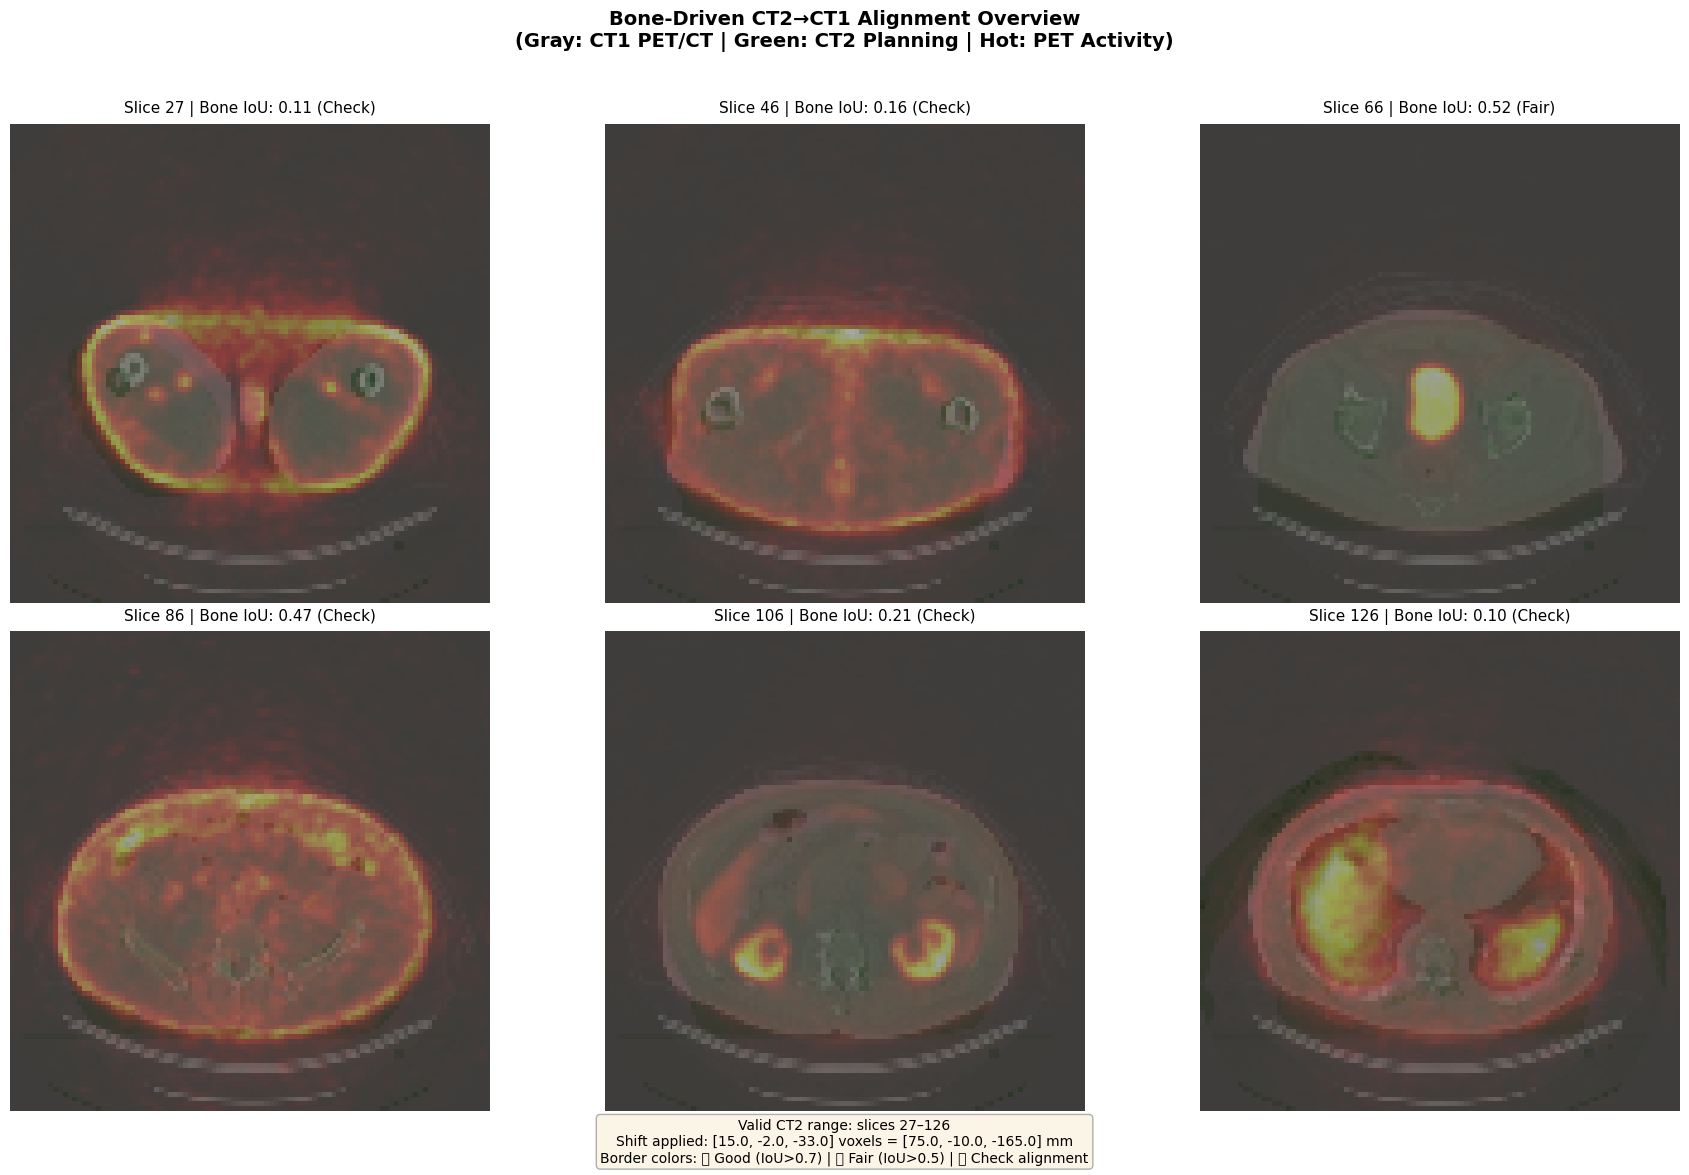


✅ Alignment overview complete!


In [16]:
# === 16. CREATE 6-PANEL ALIGNMENT OVERVIEW ===

print("\n" + "="*60)
print("GENERATING ALIGNMENT OVERVIEW")
print("="*60)

# Select 6 slices evenly spaced within valid range
if len(valid_slices) >= 6:
    indices = np.linspace(0, len(valid_slices)-1, 6, dtype=int)
    display_slices = [valid_slices[i] for i in indices]
else:
    display_slices = valid_slices
    print(f"⚠ Only {len(valid_slices)} valid slices available")

print(f"Displaying slices: {display_slices}")

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, slice_num in enumerate(display_slices):
    if idx >= 6:
        break
    
    slice_num = int(np.clip(slice_num, 0, ct1_iso.shape[2] - 1))
    
    ax = axes[idx]
    
    # Base: CT1 grayscale
    ax.imshow(ct1_iso[:, :, slice_num], cmap='gray', vmin=-1000, vmax=3000, alpha=1.0)
    
    # Overlay 1: CT2 in green
    ax.imshow(CT2_aligned[:, :, slice_num], cmap='Greens', alpha=0.35, vmin=-1000, vmax=3000)
    
    # Overlay 2: PET in hot
    ax.imshow(pet_aligned[:, :, slice_num], cmap='hot', alpha=0.30)
    
    # Compute bone IoU for this slice
    iou = compute_bone_iou(ct1_iso[:, :, slice_num], CT2_aligned[:, :, slice_num])
    
    # Classify alignment quality
    if iou > 0.7:
        quality = "Good"
        border_color = 'green'
    elif iou > 0.5:
        quality = "Fair"
        border_color = 'yellow'
    else:
        quality = "Check"
        border_color = 'red'
    
    # Title with IoU
    ax.set_title(f'Slice {slice_num} | Bone IoU: {iou:.2f} ({quality})', 
                 fontsize=11, pad=8)
    ax.axis('off')
    
    # Border color coding
    for spine in ax.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)
        spine.set_visible(True)

# Overall title
fig.suptitle(
    'Bone-Driven CT2→CT1 Alignment Overview\n'
    '(Gray: CT1 PET/CT | Green: CT2 Planning | Hot: PET Activity)',
    fontsize=14, fontweight='bold'
)

# Legend
legend_text = (
    f"Valid CT2 range: slices {min(valid_slices)}–{max(valid_slices)}\n"
    f"Shift applied: {shift_vox.tolist()} voxels = {shift_mm.tolist()} mm\n"
    f"Border colors: 🟢 Good (IoU>0.7) | 🟡 Fair (IoU>0.5) | 🔴 Check alignment"
)
fig.text(0.5, 0.02, legend_text, ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()

print("\n✅ Alignment overview complete!")

# Registration Complete

**Summary:**
- ✅ CT1 (PET/CT), PET, and CT2 (Planning) loaded and resampled to 5mm isotropic
- ✅ PET aligned to CT1 coordinate system
- ✅ CT2 rigidly registered to CT1 using bone-driven phase correlation
- ✅ Multi-slice overlay visualization with quality metrics

**Next Steps:**
1. Verify alignment quality on displayed slices
2. Use aligned volumes for PET-avid target contouring
3. Export contours to treatment planning system

**Variables available:**
- `ct1_iso`: Original PET/CT (reference)
- `pet_aligned`: PET aligned to CT1
- `CT2_aligned`: Planning CT aligned to CT1
- `valid_slices`: List of slice indices where CT2 has data
- `shift_vox`, `shift_mm`: Applied transformation

In [17]:
# === OPTIONAL: SAVE ALIGNMENT PARAMETERS ===

alignment_summary = {
    'ct1_shape': ct1_iso.shape,
    'ct2_shape': ct2_iso.shape,
    'pet_shape': pet_iso.shape,
    'shift_voxels': shift_vox.tolist(),
    'shift_mm': shift_mm.tolist(),
    'correlation_error': float(error),
    'valid_slice_range': [int(min(valid_slices)), int(max(valid_slices))],
    'bone_iou_mid': float(iou_mid) if 'iou_mid' in locals() else None
}

print("\n" + "="*60)
print("ALIGNMENT SUMMARY")
print("="*60)
for key, value in alignment_summary.items():
    print(f"{key}: {value}")


ALIGNMENT SUMMARY
ct1_shape: (100, 100, 220)
ct2_shape: (100, 100, 100)
pet_shape: (137, 137, 221)
shift_voxels: [15.0, -2.0, -33.0]
shift_mm: [75.0, -10.0, -165.0]
correlation_error: nan
valid_slice_range: [27, 126]
bone_iou_mid: 0.12060301507537688


In [18]:
# ...existing code...

# === EXPORT: WRITE A SINGLE PATIENT/STUDY WITH 3 SERIES (CT1, CT2, PET) ===
import os
import time
import numpy as np
import pydicom
from pydicom.dataset import Dataset, FileMetaDataset
from pydicom.uid import generate_uid, ExplicitVRLittleEndian

# Output root; Slicer can import this single folder
output_dir = r'c:\Users\zhaoanr\Desktop\CorrectedImages2'
os.makedirs(output_dir, exist_ok=True)

# Derive patient label from input folder (or set manually)
patient_id = "CorrectedPatient01"
patient_name = "Corrected^Patient"

# Use one StudyInstanceUID and one FrameOfReferenceUID for all three series so Slicer groups
study_uid = generate_uid()
for_uid = generate_uid()

# Series UIDs (one per series)
series_uids = {
    "CT1": generate_uid(),
    "CT2": generate_uid(),
    "PET": generate_uid(),
}

# Common geometry pulled from CT1 (all aligned in this notebook)
spacing_row, spacing_col, spacing_slc = ct1_iso_meta['spacing']
origin = np.array(ct1_iso_meta['origin'], dtype=float)
iop = [float(x) for x in ct1_iso_meta['orientation']]
row_cos = np.array(iop[0:3], dtype=float)
col_cos = np.array(iop[3:6], dtype=float)
slc_cos = np.cross(row_cos, col_cos)
slc_cos = slc_cos / (np.linalg.norm(slc_cos) + 1e-8)

# Helper: DICOM File Meta
def make_file_meta(sop_class_uid, sop_instance_uid):
    fm = FileMetaDataset()
    fm.FileMetaInformationVersion = b'\x00\x01'
    fm.MediaStorageSOPClassUID = sop_class_uid
    fm.MediaStorageSOPInstanceUID = sop_instance_uid
    fm.TransferSyntaxUID = ExplicitVRLittleEndian
    fm.ImplementationClassUID = pydicom.uid.PYDICOM_IMPLEMENTATION_UID
    return fm

# Helper: create a minimal but well‑formed image Dataset
def new_image_ds(rows, cols, modality, series_desc, series_uid, series_number,
                 iop_list, ipp_xyz, pixel_spacing, slice_thickness,
                 photometric="MONOCHROME2", pixel_repr=1,
                 rescale_slope=1.0, rescale_intercept=0.0,
                 sop_class_uid="1.2.840.10008.5.1.4.1.1.2"  # CT Image Storage default
                 ):
    ds = Dataset()
    # Patient/Study
    ds.PatientName = patient_name
    ds.PatientID = patient_id
    ds.StudyInstanceUID = study_uid
    ds.StudyDate = time.strftime("%Y%m%d")
    ds.StudyTime = time.strftime("%H%M%S")

    # Series
    ds.Modality = modality
    ds.SeriesInstanceUID = series_uid
    ds.SeriesNumber = series_number
    ds.SeriesDescription = series_desc
    ds.FrameOfReferenceUID = for_uid

    # Image geometry
    ds.ImageOrientationPatient = [float(x) for x in iop_list]
    ds.ImagePositionPatient = [float(x) for x in ipp_xyz]
    ds.PixelSpacing = [float(pixel_spacing[0]), float(pixel_spacing[1])]
    ds.SliceThickness = float(slice_thickness)
    ds.SpacingBetweenSlices = float(slice_thickness)

    # Pixel module
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = photometric
    ds.Rows = int(rows)
    ds.Columns = int(cols)
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = int(pixel_repr)  # 0=unsigned, 1=signed
    ds.RescaleSlope = float(rescale_slope)
    ds.RescaleIntercept = float(rescale_intercept)
    ds.WindowCenter = 40
    ds.WindowWidth = 400

    # SOP
    ds.SOPClassUID = sop_class_uid
    sop_iuid = generate_uid()
    ds.SOPInstanceUID = sop_iuid
    ds.file_meta = make_file_meta(sop_class_uid, sop_iuid)

    # Encoding
    ds.is_implicit_VR = False
    ds.is_little_endian = True
    return ds

# Writer for one series
def write_series(volume, series_name, modality, series_number, pixel_repr,
                 rescale_slope, rescale_intercept, sop_class_uid, scale_clamp=None):
    series_path = os.path.join(output_dir, series_name)
    os.makedirs(series_path, exist_ok=True)

    R, C, K = volume.shape

    # Convert intensities to stored 16‑bit according to PixelRepresentation and rescale
    if pixel_repr == 1:  # signed int16 (CT)
        v = np.copy(volume)
        if scale_clamp is not None:
            v = np.clip(v, scale_clamp[0], scale_clamp[1])
        stored = np.round((v - rescale_intercept) / rescale_slope).astype(np.int16)
    else:  # unsigned int16 (PET)
        v = np.maximum(volume, 0.0)
        if scale_clamp is not None:
            v = np.clip(v, scale_clamp[0], scale_clamp[1])
        stored = np.round((v - rescale_intercept) / rescale_slope).astype(np.uint16)

    for k in range(K):
        ipp = origin + slc_cos * spacing_slc * k  # first pixel (row=0,col=0) of slice k

        ds = new_image_ds(
            rows=R, cols=C,
            modality=modality,
            series_desc=f"{series_name} (Aligned)",
            series_uid=series_uids[series_name],
            series_number=series_number,
            iop_list=iop,
            ipp_xyz=ipp.tolist(),
            pixel_spacing=[spacing_row, spacing_col],
            slice_thickness=spacing_slc,
            photometric="MONOCHROME2",
            pixel_repr=pixel_repr,
            rescale_slope=rescale_slope,
            rescale_intercept=rescale_intercept,
            sop_class_uid=sop_class_uid
        )

        ds.InstanceNumber = int(k + 1)
        ds.ImageType = ['DERIVED', 'SECONDARY']
        ds.AcquisitionNumber = 1
        ds.ContentDate = ds.StudyDate
        ds.ContentTime = ds.StudyTime

        ds.PixelData = stored[:, :, k].tobytes(order='C')

        out_path = os.path.join(series_path, f"{series_name}_{k+1:04d}.dcm")
        pydicom.dcmwrite(out_path, ds, write_like_original=False)

    print(f"✓ Wrote {K} slices to {series_path}")

# CT1 series (signed int16 HU, clamp to typical HU range)
write_series(
    volume=ct1_iso,
    series_name="CT1",
    modality="CT",
    series_number=1,
    pixel_repr=1,
    rescale_slope=1.0,
    rescale_intercept=0.0,
    sop_class_uid="1.2.840.10008.5.1.4.1.1.2",           # CT Image Storage
    scale_clamp=(-1024, 3071)
)

# CT2 series (signed int16 HU)
write_series(
    volume=CT2_aligned,
    series_name="CT2",
    modality="CT",
    series_number=2,
    pixel_repr=1,
    rescale_slope=1.0,
    rescale_intercept=0.0,
    sop_class_uid="1.2.840.10008.5.1.4.1.1.2",
    scale_clamp=(-1024, 3071)
)

# PET series (unsigned int16; store with slope so real = stored * 0.01)
pet_scale = 0.01  # 1 stored unit = 0.01 real units
write_series(
    volume=pet_aligned,
    series_name="PET",
    modality="PT",
    series_number=3,
    pixel_repr=0,
    rescale_slope=pet_scale,
    rescale_intercept=0.0,
    sop_class_uid="1.2.840.10008.5.1.4.1.1.128",         # PET Image Storage
    scale_clamp=(0.0, 65535 * pet_scale)
)

print("\nDICOM export complete.")
print(f"PatientID: {patient_id}")
print(f"StudyInstanceUID: {study_uid}")
print(f"FrameOfReferenceUID: {for_uid}")
print(f"Output folder ready for 3D Slicer import: {output_dir}")

# ...existing code...

✓ Wrote 220 slices to c:\Users\zhaoanr\Desktop\CorrectedImages2\CT1
✓ Wrote 220 slices to c:\Users\zhaoanr\Desktop\CorrectedImages2\CT2
✓ Wrote 220 slices to c:\Users\zhaoanr\Desktop\CorrectedImages2\PET

DICOM export complete.
PatientID: CorrectedPatient01
StudyInstanceUID: 1.2.826.0.1.3680043.8.498.56696675535502900228030560482561982146
FrameOfReferenceUID: 1.2.826.0.1.3680043.8.498.94067953454865424757142727090796454946
Output folder ready for 3D Slicer import: c:\Users\zhaoanr\Desktop\CorrectedImages2
